In [1]:
import math, sys, os, time
import numpy as np, pandas as pd
import scipy as sp, random as rd
import argparse

from matplotlib import pyplot as plt, rcParams, animation, rc
from mpl_toolkits.mplot3d import Axes3D
from __future__ import print_function, division
from ipywidgets import interact, interactive, fixed
from ipywidgets.widgets import *

from sklearn.datasets.samples_generator import make_regression, make_blobs
from sklearn.linear_model import SGDClassifier, SGDRegressor, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

## 1. Demonstrate gradient descent to minimize a function
Define a polynomial function, where its derivative is known analytically. Then take tiny gradient descent steps to minimize. The polynomial is $f(x)$, and we wish to find the $x$ that yields a minimum.

In [2]:
x_current = 6 # The algorithm starts at x=6
mu = 0.01 # learning rate, a step size multiplier. Try both higher and lower learning rates
precision = 0.00001 # when to stop (how is precision used here?)
previous_step_size = x_current
a1, b1, c1, l1, m1 = 1, -5, 2, 4, 3

# A polynomial to be minimized
def f(x): 
    y = a1 * x**l1 + b1 * x**m1 + c1
    return y

# Polynomial's derivative with respect to x
def dfdx(x):
    y = a1 * l1 * x**(l1-1) + b1 * m1 * x**(m1-1)
    return y

i = 0 # step number
# Gradient descent
while previous_step_size > precision:
    i = i + 1
    x_previous = x_current
    delta_x = -mu * dfdx(x_previous)
    print("step ", i, ": deltax = ", delta_x)
    x_current += delta_x
    previous_step_size = abs(x_current - x_previous)
    
print("The local minimum occurs at %f" % x_current)

step  1 : deltax =  -3.24
step  2 : deltax =  0.30165696
step  3 : deltax =  0.2580940394931406
step  4 : deltax =  0.18966661007709149
step  5 : deltax =  0.11852062390017039
step  6 : deltax =  0.0642627655142266
step  7 : deltax =  0.031517444337226835
step  8 : deltax =  0.014576885693134329
step  9 : deltax =  0.006542841773488135
step  10 : deltax =  0.002895541088608695
step  11 : deltax =  0.0012732467161737304
step  12 : deltax =  0.000558289991091101
step  13 : deltax =  0.00024449097195116564
step  14 : deltax =  0.00010701064014455141
step  15 : deltax =  4.682593536301738e-05
step  16 : deltax =  2.0488027849410174e-05
step  17 : deltax =  8.963834006578964e-06
The local minimum occurs at 3.749993


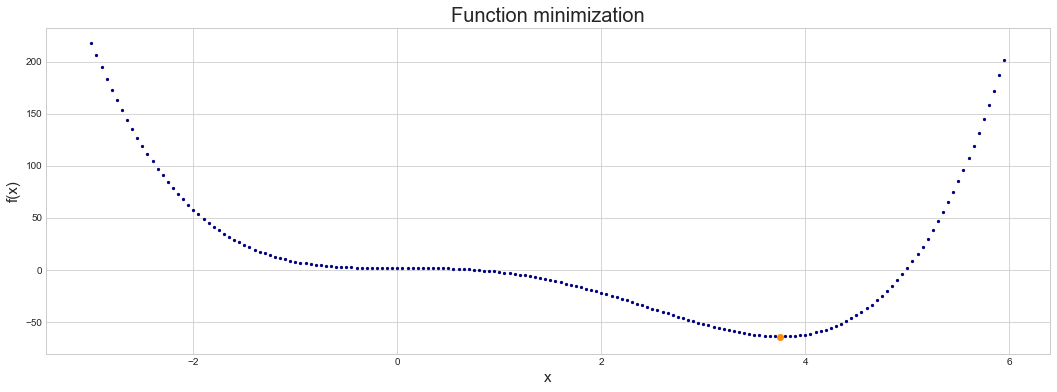

In [3]:
plt.figure(figsize = (18, 6))
plt.style.use('seaborn-whitegrid')
plt.scatter(np.arange(-3, 6, 0.05), f(np.arange(-3, 6, 0.05)), s=5, c='navy')
plt.scatter(x_current, f(x_current), c='darkorange');
plt.title('Function minimization', fontsize=20)
plt.xlabel('x', fontsize=15)
plt.ylabel('f(x)', fontsize=15);

## 2. Gradient descent for multivariable function
A polynomial $f(x_1, x_2)$, where the gradient is expressed in terms of partial derivatives with respect to $x_1$ and $x_2$. Find the $w_1, w_2$ that yield a minimum for $f(w_1, w_2)$. Again, the gradient is known analytically.

In [4]:
# Now the polynomial is a function of x1 and x2
x1_array = np.linspace(-2., 2., 15)
x2_array = np.linspace(-1., 3., 15)
def f1(x1, x2):
    z = (1 - x1) ** 2 + 100 * (x2 - x1**2)**2
    return (z)
z = f1(x1_array, x2_array)

def dfdx1(x1, x2):
    return -2 * (1 - x1) - 400 * (x2 - x1**2) * x1

def dfdx2(x1, x2):
    return 200 * (x2 - x1**2)

# what's the shape of the array returned by dfdx?
def dfdx(x1, x2):
  return np.array([[dfdx1(x1, x2), dfdx2(x1, x2)]]).T

w_previous = np.array([[0,0]]).reshape((2,1)) 
w_current = np.array([-1.8,-0.8]).reshape((2,1)) # initial guess (try random value)
previous_step_size = np.linalg.norm(w_current)
mu = 0.0002 # the learning rate
precision = 0.00001 # the precision

# Perform Gradient Descent
i = 0
while previous_step_size > precision:
    i = i + 1
    w_previous = np.copy(w_current)
    delta_w = -mu * dfdx(w_current[0,0], w_current[1,0])
    #print("step ", i, ": deltaw = ", delta_w)
    w_current += delta_w
    previous_step_size = np.linalg.norm(w_previous - w_current)

print ("The local minimum occurs at ", w_current)
print ("with f = ", f1(w_current[0,0], w_current[1,0]))
print ("after ", i, " steps")

The local minimum occurs at  [[0.94648413]
 [0.89561108]]
with f =  0.0028688380432432357
after  23374  steps


## 3. Linear regression

Sklearn has functions for linear regression. This includes generating noisy data for regression, then performing the regression, and finally evaluating it. The algorithm is least squares pseudoinverse.

In [5]:
x1, y1 = make_regression(n_samples = 100, n_features=1, n_informative=1, noise=20, random_state=0)

regLS = LinearRegression().fit(x1, y1) # returns a regression object
print("Linear regression slope = ", regLS.coef_, "intercept = ", regLS.intercept_)
predictLS = regLS.coef_ * x1[:,0] + regLS.intercept_
rsquaredLS = 1 - sum((predictLS - y1)**2)/sum(y1**2) # compute rsquared by hand
print("rsquared = ", rsquaredLS, "score = ", regLS.score(x1, y1)) # and compare with sklearn

Linear regression slope =  [42.85335573] intercept =  -1.628363654061452
rsquared =  0.8034096774808257 score =  0.8033357286556448


## 4. Gradient descent for linear regression
A simple function demonstrates the iterative change in weights. Here the function acts for a fixed number of iterations.

In [6]:
def gradient_descent1(x, y, iterations, mu):
    """
    Uses gradient descent to form linear regression of x input and y output.
    Performs 'iterations' steps, using learning rate 'mu'.
    """
    costs = []
    predictions = []
    n = y.size 
    ws = np.random.rand(x.shape[1]) # start with random weights
    history = [ws] 
    
    for i in range(iterations):
        prediction = np.dot(x, ws)
        if i % 10 == 0: predictions.append(prediction)
        
        error = prediction - y 
        cost = np.sum(error ** 2) / (2 * n)
        costs.append(cost)

        gradient = x.T.dot(error)/n 
        ws = ws - mu * gradient  
        history.append(ws)

    return history, costs, predictions

Compare gradient descent against least squares

In [8]:
xwith1s = np.c_[np.ones(x1.shape[0]), x1] # what is this?
mu1 = 0.05 
iters1 = 1000
historyGD, costGD, predictions = gradient_descent1(xwith1s, y1, iters1, mu1)
w1 = historyGD[-1] # last element is the solution
predictGD = np.dot(xwith1s, w1)

print("Gradient Descent: {:.2f}, {:.2f}".format(w1[0], w1[1]))
print("Least Squares: {:.2f}, {:.2f}".format(regLS.intercept_, regLS.coef_[0]))

Gradient Descent: -1.63, 42.85
Least Squares: -1.63, 42.85


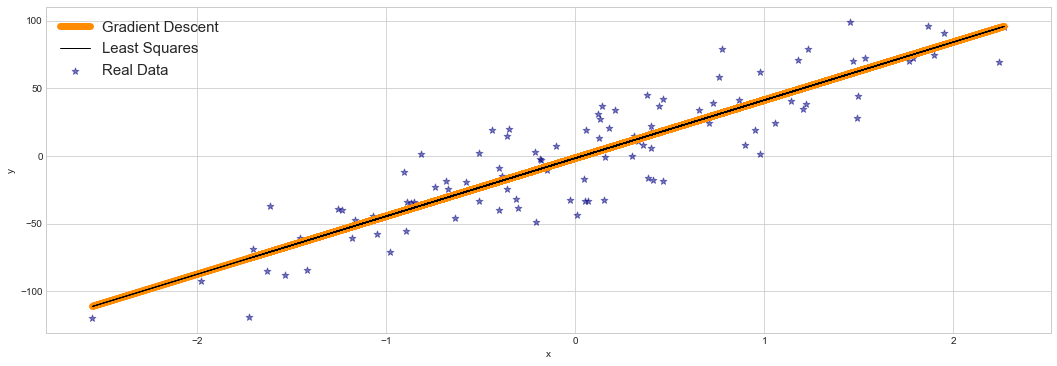

In [15]:
# Plot gradient descent and least squares together
plt.figure(figsize = (18, 6))
plt.scatter(x1, y1, c='navy', s=50, marker='*', alpha=0.5, label='Real Data')
plt.plot(x1, predictGD, c='darkorange', linewidth=7, label='Gradient Descent')
plt.plot(x1, predictLS, c='black', linewidth=1, label='Least Squares')
plt.legend(fontsize=15)
plt.xlabel('x')
plt.ylabel('y');

Examine change in weights during descent

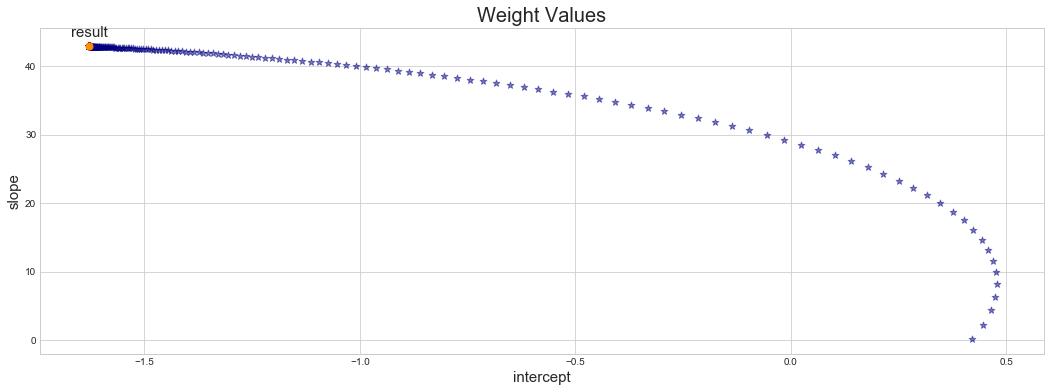

In [16]:
history = np.array(historyGD)
plt.figure(figsize = (18, 6))
plt.scatter(history[:, 0], history[:, 1], c='navy', s=50, marker='*', alpha=0.5)
plt.scatter(w1[0], w1[1], c='darkorange', s=50)
plt.annotate('result', xy=(w1[0], w1[1]+1), ha='center', va='bottom', fontsize=15)
plt.title('Weight Values', fontsize=20)
plt.xlabel('intercept', fontsize=15)
plt.ylabel('slope', fontsize=15);

Plot the error surface a a function of the weights

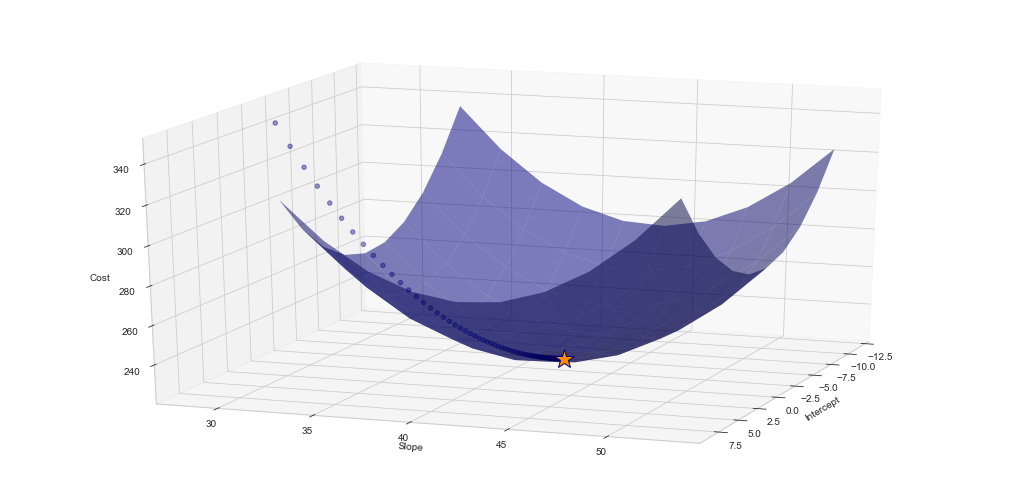

In [17]:
def error(x, y, ws):
    return np.sum((x.dot(ws) - y)**2)/(2*y.size)

b1 = np.linspace(w1[0] - 10 , w1[0] + 10, 10)
a1 = np.linspace(w1[1] - 10 , w1[1] + 10, 10)

A1, B1 = np.meshgrid(a1, b1)

z1 = np.array([error(xwith1s, y1, w) 
               for w in zip(np.ravel(B1), np.ravel(A1))]) # ravel flattens arrays
Z1 = z1.reshape(A1.shape)

fig = plt.figure(figsize=(18, 9))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(B1, A1, Z1, color='navy', alpha=0.5)
ax.scatter(history[21:, 0], history[21:, 1], costGD[20:], color='navy', alpha=0.4)
ax.set_xlabel('Intercept')
ax.set_ylabel('Slope')
ax.set_zlabel('Cost')
ax.view_init(elev=20., azim=20)
ax.plot([w1[0]], [w1[1]], [costGD[-1]] , 
        markerfacecolor='darkorange', markeredgecolor='navy', marker='*', markersize=20);
